In [9]:
#1. Import Libraries

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from preprocess import load_retina_data


In [89]:
 #Open your original CSV

import pandas as pd

# Load your original training CSV
df = pd.read_csv(r"C:\Users\rithi\diabetes_detection_project\stage2_retinal\data\train.csv")

# Show how many images are there in each class
print(df['diagnosis'].value_counts())


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


In [91]:
 #Balance Your Dataset (Undersample)

# Find the smallest class size
min_class_size = df['diagnosis'].value_counts().min()  # will be 193

# Balance all classes to match the smallest one
balanced_df = df.groupby('diagnosis').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

# Save this balanced dataset to a new CSV
balanced_df.to_csv(r"C:\Users\rithi\diabetes_detection_project\stage2_retinal\data\balanced_train.csv", index=False)

# Confirm it's balanced
print(balanced_df['diagnosis'].value_counts())



diagnosis
0    193
1    193
2    193
3    193
4    193
Name: count, dtype: int64


C:\Users\rithi\AppData\Local\Temp\ipykernel_33552\105183095.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('diagnosis').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)


In [93]:
#2. Load Preprocessed Data

X_train, X_val, y_train, y_val = load_retina_data(
    csv_path=r"C:\Users\rithi\diabetes_detection_project\stage2_retinal\data\train.csv",
    img_dir=r"C:\Users\rithi\diabetes_detection_project\stage2_retinal\data\train_images"
)




In [94]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot labels to integers for computing weights
y_integers = np.argmax(y_train, axis=1)

# Compute class weights based on frequency
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)

# Convert to dictionary format required by Keras
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.402888583218707, 1: 1.9397350993377482, 2: 0.7452926208651399, 3: 3.7312101910828024, 4: 2.5469565217391303}


In [120]:
#3. Build the CNN Model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build base model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# ✅ UNFREEZE top 20 layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

# 🔁 Recompile with focal loss instead of categorical crossentropy
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)


In [122]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return loss_fn


In [124]:
# Add Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Apply it to your training set
datagen.fit(X_train)




In [126]:
# 5. Train the Model

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("retina_cnn_model.h5", save_best_only=True)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)




C:\Users\rithi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.3514 - loss: 0.2424

92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 835ms/step - accuracy: 0.3522 - loss: 0.2422 - val_accuracy: 0.0887 - val_loss: 0.2583
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 613ms/step - accuracy: 0.4802 - loss: 0.2020 - val_accuracy: 0.0491 - val_loss: 0.2655
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.4702 - loss: 0.1965

92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 640ms/step - accuracy: 0.4703 - loss: 0.1965 - val_accuracy: 0.0887 - val_loss: 0.2493
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.4755 - loss: 0.2025

92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 642ms/step - accuracy: 0.4755 - loss: 0.2024 - val_accuracy: 0.4789 - val_loss: 0.2216
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.4759 - loss: 0.2013

92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 650ms/step - accuracy: 0.4760 - loss: 0.2013 - val_accuracy: 0.4789 - val_loss: 0.2030
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.4743 - loss: 0.1962

92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 630ms/step - accuracy: 0.4744 - loss: 0.1963 - val_accuracy: 0.4789 - val_loss: 0.1983
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.4842 - loss: 0.1988

92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 627ms/step - accuracy: 0.4841 - loss: 0.1987 - val_accuracy: 0.4789 - val_loss: 0.1971
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 628ms/step - accuracy: 0.4910 - loss: 0.1960 - val_accuracy: 0.4789 - val_loss: 0.1976
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4730 - loss: 0.2042

92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 628ms/step - accuracy: 0.4731 - loss: 0.2041 - val_accuracy: 0.4789 - val_loss: 0.1938
Epoch 10/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.5043 - loss: 0.1967

92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 695ms/step - accuracy: 0.5041 - loss: 0.1967 - val_accuracy: 0.4789 - val_loss: 0.1910
Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 812ms/step - accuracy: 0.4765 - loss: 0.1924 - val_accuracy: 0.4789 - val_loss: 0.1931
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.4853 - loss: 0.1939 - val_accuracy: 0.4789 - val_loss: 0.1943
Epoch 13/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 986ms/step - accuracy: 0.4938 - loss: 0.1884 - val_accuracy: 0.4789 - val_loss: 0.1947


23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 510ms/step


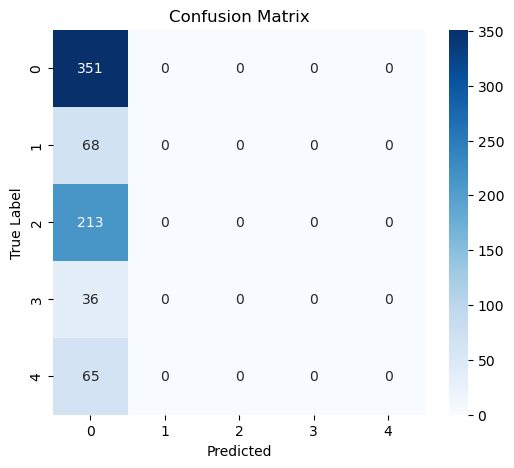

Classification Report:

              precision    recall  f1-score   support

           0      0.479     1.000     0.648       351
           1      0.000     0.000     0.000        68
           2      0.000     0.000     0.000       213
           3      0.000     0.000     0.000        36
           4      0.000     0.000     0.000        65

    accuracy                          0.479       733
   macro avg      0.096     0.200     0.130       733
weighted avg      0.229     0.479     0.310       733



C:\Users\rithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [128]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices
y_true = np.argmax(y_val, axis=1)         # actual class indices

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3))


In [7]:
!pip install opencv-python



   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 1.2 MB/s eta 0:00:33
    --------------------------------------- 0.8/39.5 MB 1.1 MB/s eta 0:00:35
   - -------------------------------------- 1.0/39.5 MB 1.2 MB/s eta 0:00:33
   - -------------------------------------- 1.3/39.5 MB 1.2 MB/s eta 0:00:31
   - -------------------------------------- 1.6/39.5 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.8/39.5 MB 1.3 MB/s eta 0:00:30
   -- ------------------------------------- 2.4/39.5 MB 1.4 MB/s eta 0:00:27
   -- ------------------------------------- 2.6/39.5 MB 1.5 MB/s eta 0:00:26
   -- ------------------------------------- 2.9/39.5 MB 1.4 MB/s eta 0:00:27
   --- ------------------------------------ 3.1/39.5 MB 1.4 MB/s eta 0:00:27
   --- ------------------------------------ 3.1/39.5 MB 1.4 MB/s eta 0:00:27
   --- ------

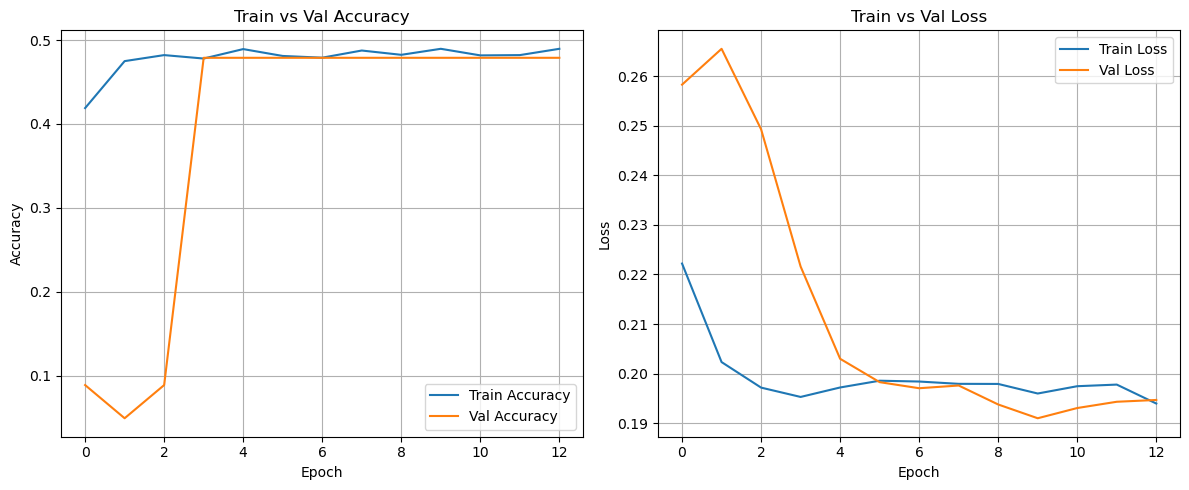

In [130]:
#1. Plot Training & Validation Accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Train vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()







In [158]:
# Get Image Predictions from CNN

from tensorflow.keras.models import load_model
import pickle
import pandas as pd

# --- Step 1: Load original clinical CSV to get correct test indices mapping ---
df = pd.read_csv(r"C:\Users\rithi\diabetes_detection_project\stage1_clinical_ml\diabetes.csv")
X = df.drop("Outcome", axis=1)  # X will be used to get correct index reference

# --- Step 2: Load trained CNN model ---
cnn_model = load_model("retina_cnn_model.h5", compile=False)

# --- Step 3: Load saved validation indices (used during Stage 1 split) ---
with open("val_indices.pkl", "rb") as f:
    val_indices = pickle.load(f)

# --- Step 4: Convert indices to relative positions in image data (match order) ---
val_indices_relative = [X.index.get_loc(i) for i in val_indices]
val_indices_relative = [i for i in val_indices_relative if i < len(X_val)]  # safeguard

# --- Step 5: Align image validation data ---
X_val_aligned = X_val[val_indices_relative]

# --- Step 6: Predict using CNN model ---
image_preds = cnn_model.predict(X_val_aligned)
print("Image prediction shape:", image_preds.shape)

# --- Step 7: Load clinical model and get predictions ---
with open("model.pkl", "rb") as f:
    clinical_model = pickle.load(f)

# Get full clinical predictions on entire data (same as what model saw)
clinical_preds = clinical_model.predict_proba(X)

# --- Step 8: Align clinical predictions using same indices ---
clinical_preds_aligned = clinical_preds[val_indices_relative]
print("Aligned Clinical predictions shape:", clinical_preds_aligned.shape)
print("Aligned Image predictions shape:", image_preds.shape)





5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step
Image prediction shape: (144, 5)
Aligned Clinical predictions shape: (144, 2)
Aligned Image predictions shape: (144, 5)



Fusion Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        50

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



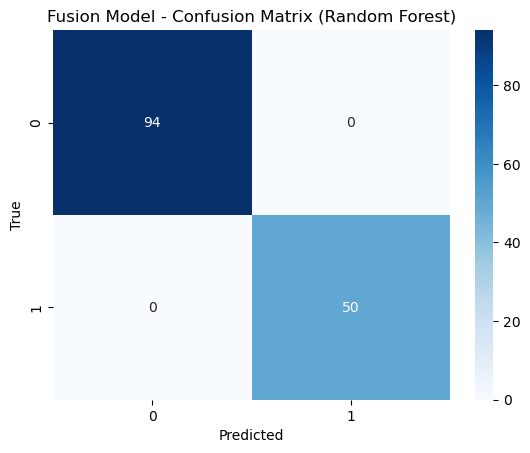

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np  # just in case it's not already imported

# Step 3.1: Concatenate predictions (clinical + image)
fusion_X = np.concatenate([clinical_preds_aligned, image_preds], axis=1)

# Step 3.2: Load true labels directly from diabetes.csv using val_indices
df = pd.read_csv(r"C:\Users\rithi\diabetes_detection_project\stage1_clinical_ml\diabetes.csv")
y_all = df["Outcome"]

with open("val_indices.pkl", "rb") as f:
    val_indices = pickle.load(f)

# Ensure valid indices and get labels
val_indices = [i for i in val_indices if i < len(y_all)]
y_val = y_all.loc[val_indices].iloc[:len(fusion_X)].values

# ✅ Step 4B.1: Train Random Forest on fused predictions
fusion_model = RandomForestClassifier(n_estimators=100, random_state=42)
fusion_model.fit(fusion_X, y_val)

# ✅ Step 4B.2: Predict and evaluate
fusion_preds = fusion_model.predict(fusion_X)

# ✅ Step 4B.3: Classification report
print("\nFusion Classification Report (Random Forest):")
print(classification_report(y_val, fusion_preds))

# ✅ Step 4B.4: Confusion matrix
cm = confusion_matrix(y_val, fusion_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Fusion Model - Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [168]:
import joblib
joblib.dump(fusion_model, "fusion_rf_model.pkl")


['fusion_rf_model.pkl']